In [1]:
import pickle
import numpy as np

tsdir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
demofile = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/demographics.pkl'
tsdict = dict()

for task in ['rest']:
    item = pickle.load(open(f'{tsdir}/PNC_SPM_{task}_good_filt.pkl', 'rb'))
    tsdict[task] = item
    
rest = []
age = []

demo = pickle.load(open(demofile, 'rb'))

for sub in demo['age_at_cnb']:
    try:
        tsr = tsdict['rest'][sub]
        a = demo['age_at_cnb'][sub]
    except:
        continue
    rest.append(tsr)
    age.append(a)

rest = np.stack(rest)
age = np.array(age)

print([a.shape for a in [rest, age]])

[(1387, 264, 124), (1387,)]


In [2]:
# Calculate windowed FC

restwin = []
wsize = 20

for i in range(rest.shape[0]):
    subfc = []
    for j in range(0,rest.shape[-1],wsize):
        samp = rest[i,:,j:j+wsize]
        fc = np.corrcoef(samp)
        subfc.append(fc)
    restwin.append(np.stack(subfc))

restwin = np.stack(restwin)
print(restwin.shape)

(1387, 7, 264, 264)


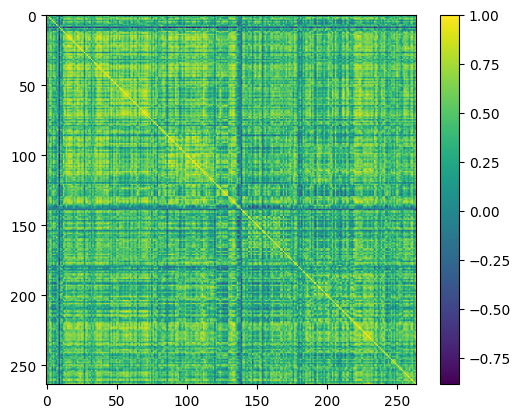

In [3]:
import matplotlib.pyplot as plt

plt.imshow(restwin[0,5])
plt.colorbar()
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(xhat, xt):
    return torch.mean((xt-xhat)**2)**0.5

class DD(nn.Module):
    def __init__(self, n, t, d, e, rank):
        super(DD, self).__init__()
        self.A = nn.Parameter(torch.randn(d, 264, rank).float().cuda())
        self.B = nn.Parameter(torch.randn(e, 264, 264).float().cuda())
        self.u = nn.Parameter(torch.randn(n, t, d).float().cuda())
        self.v = nn.Parameter(torch.randn(n, t, e).float().cuda())
        
    def expand(self):
        A = torch.einsum('dar,dbr->dab', self.A, self.A)
        col = torch.arange(264).long().cuda()
        A[:,col,col] = 1
        return A
        
    def estimate(self, nlo, nhi):
        A = self.expand()
        B = self.B
        x1 = torch.einsum('ntd,dab->ntab', self.u[nlo:nhi], A)
        x2 = torch.einsum('ntd,dab->ntab', self.v[nlo:nhi], B)
        return x1+x2
        
dd = DD(restwin.shape[0], restwin.shape[1], 10, 100, 2)
optim = torch.optim.Adam(dd.parameters(), lr=1e-2, weight_decay=0)

nepochs = 1000
pperiod = 10
bsize = 100

x = torch.from_numpy(restwin).float().cuda()

for e in range(nepochs):
    for b in range(0,x.shape[0],bsize):
        optim.zero_grad()
        xhat = dd.estimate(b, b+bsize)
        loss = rmse(xhat, x[b:b+bsize])
        loss.backward()
        optim.step()
        if e % pperiod == 0 or e == nepochs-1:
            print(f'{e} {loss}')
        
print('Complete')

0 10.985747337341309
0 10.874250411987305
0 10.810269355773926
0 10.667747497558594
0 10.626221656799316
0 10.444680213928223
0 10.42127513885498
0 10.303690910339355
0 10.205698013305664
0 10.15903091430664
0 10.03662109375
0 9.96843433380127
0 9.919818878173828
0 9.801031112670898
10 2.0930898189544678
10 2.0713725090026855
10 2.046827554702759
10 2.0122828483581543
10 1.9887430667877197
10 1.9437825679779053
10 1.9328557252883911
10 1.8995033502578735
10 1.870931625366211
10 1.8457684516906738
10 1.8134827613830566
10 1.790216088294983
10 1.773951768875122
10 1.733432650566101


KeyboardInterrupt: 